'''
In this script, we perform topic modeling using the LDA approach (Python sklearn package).

Topic Modeling is a technique to extract the hidden topics from large volumes of text. Latent Dirichlet Allocation(LDA) is a popular algorithm for topic modeling with excellent implementations in the Python’s Gensim package. The challenge, however, is how to extract good quality of topics that are clear, segregated and meaningful. This depends heavily on the quality of text preprocessing and the strategy of finding the optimal number of topics. This tutorial attempts to tackle both of these problems.

One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

Ref: https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

'''

In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [2]:
# Gensim (Topic Modeling Pacakge)
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

In [3]:
# spacy for lemmatization
import spacy
import nltk

In [4]:
# Plotting tools
#Install the package
# !pip install pyldavis
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\khoox\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [5]:
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\khoox\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# NLTK Stop words
#from nltk.corpus import stopwords
#stop_words = stopwords.words('english')
#stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [7]:
'''
We will be using the 20-Newsgroups dataset for this exercise.
This version of the dataset contains about 11k newsgroups posts from 
20 different topics. This is available as newsgroups.json.
'''
# Import Dataset
df = pd.read_csv(r'cleaned_rnn.csv', encoding='utf-8')

df = df[(df['Severe_Toxic']==0) & (df['Toxic']==1)]

df.head()

,Unnamed: 0,id,comment_text,cleaned_text,count,Severe_Toxic,Toxic,slightly_cleaned
1,1,39663d63a79f841b,==Thanks== \n For cleaning up the wp in wa issue!,thanks clean wp wa issue,20,0,1,==Thanks== For clean up the wp in wa issue !
2,2,2b8aa65b64094d44,Why are people keen to act upon their whims an...,people keen act upon whim put spoiler rather s...,283,0,1,Why be people keen to act upon their whim and ...
3,3,b21145e7025ea830,This Artist is FAKE! \n\n * \n\n https://www...,artist fake person shallow heartless quick tur...,226,0,1,This Artist be FAKE ! * ^^^^^^ Person be a sha...
4,4,4c24b0fa5c3e0db0,""" \n\n == Come by the Talk Page == \n\n Hey Bb...",come talk page hey bb come talk page redrafted...,159,0,1,`` == Come by the Talk Page == Hey Bb - Come b...
5,5,367551f928ed93bd,== Bombay Rum == \n\n I have heard several peo...,bombay rum heard several people talk bombay ru...,107,0,1,== Bombay Rum == I have hear several people ta...


In [8]:
'''
As you can see there are many emails, newline and extra spaces that is quite distracting.
Let’s get rid of them using regular expressions.
'''
# Drop rows with NAN values
df = df.dropna(axis=0)

# Convert to list
data = df.cleaned_text.values.tolist()

slightly_cleaned_data = df.slightly_cleaned.values.tolist()

# Remove new line characters
data = [re.sub('\s+', ' ', str(sent)) for sent in data]

pprint(data[:1])


['thanks clean wp wa issue']


In [9]:
print('number of datas: ', len(data))

number of datas:  6271


In [10]:
'''
After removing the emails and extra spaces, the text still looks messy.
It is not ready for the LDA to consume. You need to break down each sentence
into a list of words through tokenization, while clearing up all the messy 
text in the process.

Let’s tokenize each sentence into a list of words, removing punctuations and 
unnecessary characters altogether.

Gensim’s simple_preprocess() is great for this.
Additionally I have set deacc=True to remove the punctuations.
'''
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['thanks', 'clean', 'wp', 'wa', 'issue']]


In [11]:
'''
Bigrams are two words frequently occurring together in the document.
Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, 
quadgrams and more.

The two important arguments to Phrases are min_count and threshold.
The higher the values of these param, the harder it is for words to be combined to bigrams.
'''
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['thanks', 'clean', 'wp', 'wa', 'issue']


In [12]:
'''
The bigrams model is ready. Let’s define the functions to remove the stopwords, 
make bigrams and lemmatization and call them sequentially.
'''
# Define functions for stopwords, bigrams, trigrams and lemmatization
#def remove_stopwords(texts):
#    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
'''
Let’s call the functions in order.
'''
# Remove Stop Words
#data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
#python -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['thank', 'clean', 'issue']]


In [14]:
'''
The two main inputs to the LDA topic model are the dictionary(id2word) and the corpus.
Let’s create them.
'''
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1)]]


In [15]:
print('number of unique tokens: ', len(id2word))

number of unique tokens:  23924


'''
Gensim creates a unique id for each word in the document.
The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document.

Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

id2word[0]
'addition'

Or, you can see a human-readable form of the corpus itself.

# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('maryland_college', 1),
  (..truncated..)]]


Alright, without digressing further let’s jump back on track with the next step:

Building the topic model.
'''

In [16]:
'''
We have everything required to train the LDA model.
In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, alpha and eta are hyperparameters that affect sparsity of the topics.
According to the Gensim docs, both defaults to 1.0/num_topics prior.

chunksize is the number of documents to be used in each training chunk.

update_every determines how often the model parameters should be updated and 
passes is the total number of training passes.
'''
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=0)

In [17]:
# get the topic words only
x=lda_model.show_topics(num_topics=10, num_words=15,formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic,words in topics_words:
    print(str(topic)+ ":"+ ", ".join(words))
print()

0:wikipedia, article, thank, use, experiment, like, nonsense, time, fuck, look, add, go, say, page, sandbox
1:say, article, know, time, think, make, people, see, wikipedia, read, name, fact, give, state, mean
2:article, page, wikipedia, edit, see, use, talk, link, add, need, think, thank, name, help, source
3:window, kansa, article, descend, canadian, silva, album, fuck, day, claim, norm, overlap, rfc, time, paris
4:wikicup, chop, know, greek, gold, roman, article, read, capture, sea, wpel, bio, bunch, ec, cricketer
5:suck, think, make, wikipedia, comment, people, know, go, say, article, editor, dick, penis, revert, get
6:know, article, section, go, temperature, pa, make, fuck, change, see, comment, incorrectly, agree, page, california
7:article, know, make, think, even, people, write, wikipedia, do, go, also, try, find, name, take
8:article, page, use, wikipedia, name, thank, change, image, edit, comment, help, add, talk, see, also
9:say, article, time, go, get, make, people, wolf, al

In [18]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]



# How to interpret this?

# Topic 0 is a represented as _

# 0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” 
# + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” 
# + 0.007“back” + ‘0.006“turn”.

# It means the top 10 keywords that contribute to this topic are:
# ‘car’, ‘power’, ‘light’.. and so on
# and the weight of ‘car’ on topic 0 is 0.016.

# --> The weights reflect how important a keyword is to that topic.

# Looking at these keywords, can you guess what this topic could be?
# You may summarise it either are ‘cars’ or ‘automobiles’.

# Likewise, can you go through the remaining topic keywords and judge what the topic is?
# https://www.machinelearningplus.com/wp-content/uploads/2018/03/Inferring-Topic-from-Keywords.png


[(0,
  '0.014*"wikipedia" + 0.013*"article" + 0.013*"thank" + 0.009*"use" + '
  '0.009*"experiment" + 0.008*"like" + 0.008*"nonsense" + 0.008*"time" + '
  '0.007*"fuck" + 0.007*"look"'),
 (1,
  '0.013*"say" + 0.010*"article" + 0.008*"know" + 0.008*"time" + 0.008*"think" '
  '+ 0.007*"make" + 0.007*"people" + 0.006*"see" + 0.006*"wikipedia" + '
  '0.006*"read"'),
 (2,
  '0.035*"article" + 0.023*"page" + 0.018*"wikipedia" + 0.014*"edit" + '
  '0.010*"see" + 0.009*"use" + 0.009*"talk" + 0.008*"link" + 0.008*"add" + '
  '0.007*"need"'),
 (3,
  '0.011*"window" + 0.009*"kansa" + 0.008*"article" + 0.007*"descend" + '
  '0.006*"canadian" + 0.006*"silva" + 0.006*"album" + 0.006*"fuck" + '
  '0.006*"day" + 0.005*"claim"'),
 (4,
  '0.008*"wikicup" + 0.007*"chop" + 0.006*"know" + 0.005*"greek" + '
  '0.004*"gold" + 0.003*"roman" + 0.003*"article" + 0.003*"read" + '
  '0.003*"capture" + 0.003*"sea"'),
 (5,
  '0.021*"suck" + 0.015*"think" + 0.009*"make" + 0.008*"wikipedia" + '
  '0.006*"comment" + 0

In [19]:
'''
Model perplexity and topic coherence provide a convenient measure to judge 
how good a given topic model is. In my experience, topic coherence score, 
in particular, has been more helpful.
'''
# Compute Perplexity (lower the better)
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score (higher the better)
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

#Perplexity:  -8.86067503009

#Coherence Score:  0.532947587081


#There you have a coherence score of 0.53.



Perplexity:  -9.266181261469411

Coherence Score:  0.42586021993972833


In [20]:
'''
Now that the LDA model is built, the next step is to examine the produced 
topics and the associated keywords. There is no better tool than pyLDAvis package’s 
interactive chart and is designed to work well with jupyter notebooks.
'''
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.143864 -0.037184       1        1  28.026461
1      0.087579  0.079159       2        1  22.563604
8      0.128121 -0.057870       3        1  17.826968
7      0.068829  0.049506       4        1  12.738507
9     -0.015661  0.075787       5        1   4.869405
5     -0.031269 -0.007393       6        1   4.146553
0     -0.011281 -0.083194       7        1   3.949947
6     -0.087225 -0.004766       8        1   2.590784
3     -0.140462  0.011663       9        1   1.873478
4     -0.142497 -0.025708      10        1   1.414294, topic_info=           Term         Freq        Total Category  logprob  loglift
84         know  1290.000000  1290.000000  Default  30.0000  30.0000
6       article  4458.000000  4458.000000  Default  29.0000  29.0000
46    wikipedia  2290.000000  2290.000000  Default  28.0000  28.0000
2         thank   987.000000   987.000000  Default  27.0000  27.0000
88         page  2441.000000  2441.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
337         way     5.419193   563.392653  Topic10  -6.3426  -0.3855
88         page     5.827649  2441.818152  Topic10  -6.2699  -1.7793
95        think     5.482653  1455.100594  Topic10  -6.3310  -1.3227
1377       word     5.052213   496.543933  Topic10  -6.4127  -0.3293
46    wikipedia     5.091114  2290.307070  Topic10  -6.4051  -1.8504

[750 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
6037      4  0.965551        absurd
4946      1  0.989215       abusive
7012      3  0.033325    acceptance
7012      4  0.966427    acceptance
8103      6  0.958384  accidentally
...     ...       ...           ...
1196      7  0.068646         wrong
1196      8  0.009807         wrong
1196      9  0.009807         wrong
1196     10  0.003269         wrong
4164      6  0.873874        yankee

[2096 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 9, 8, 10, 6, 1, 7, 4, 5])

In [21]:
#Save the output to the html file
pyLDAvis.save_html(vis, "topic_viz_moderate.html")

In [22]:
#Save the data topic output to the csv file
mixture = [dict(lda_model[x]) for x in corpus]
pd.DataFrame(mixture).to_csv("topic_mixture_moderate.csv")

#To export the top words for each topic to a csv file:
top_words_per_topic = []
for t in range(lda_model.num_topics):
    top_words_per_topic.extend([(t, ) + x for x in lda_model.show_topic(t, topn = 15)])

pd.DataFrame(top_words_per_topic, columns=['Topic', 'Word', 'P']).to_csv("top_words_moderate.csv")

In [23]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, sctexts=slightly_cleaned_data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,10), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    slightly_cleaned_texts = pd.Series(sctexts)
    sent_topics_df = pd.concat([sent_topics_df, contents, slightly_cleaned_texts], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data, sctexts=slightly_cleaned_data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text', 'Slightly Cleaned']

# Show
df_dominant_topic.to_csv("topic_key_wordsrecords_Moderate.csv")

In [25]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text", "Slightly Cleaned"]

# Show
sent_topics_sorteddf_mallet.to_csv("topics_to_records_Moderate.csv")

In [26]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.to_csv("topics_distribution_Moderate.csv")

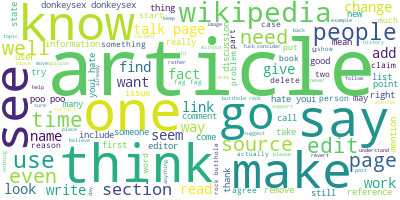

In [27]:
#Import the wordcloud library
from wordcloud import WordCloud

# Join the different processed titles together.
long_string = str(data)

# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=1000, contour_width=3, contour_color='steelblue')

# Generate a word cloud
wordcloud.generate(long_string)

# Visualize the word cloud
wordcloud.to_image()

How to choose the optimal number of the topics?
On approach to finding the optimal number of topics is to build many LDA models with different values of number of topics (k) and pick the one that gives the highest coherence value.

Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics. Picking an even higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it’s probably a sign that the ‘k’ is too large.

In [28]:
# Can take a long time to run. In this case we are going to  k_max=10.
import datetime
print(datetime.datetime.now())

from gensim.models import CoherenceModel

model_list = []
coherence_values = []
model_topics = []

for num_topics in range(1, 15, 1):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics)
#     sg_lda_x = gensim.models.wrappers.LdaMallet(mallet_path, iterations=100, corpus=sg_vecs, num_topics=no_topics, id2word=sg_dictionary)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    model_topics.append(num_topics)
    model_list.append(lda_model)
    coherence_values.append(coherence_model_lda.get_coherence())
    print("#Topics: " + str(num_topics) + " Score: " + str(coherence_model_lda.get_coherence()))

print(datetime.datetime.now())

2022-03-31 16:17:28.660077
#Topics: 1 Score: 0.6053177568677629
#Topics: 2 Score: 0.5099144360354553
#Topics: 3 Score: 0.48229075363291835
#Topics: 4 Score: 0.48586552517871706
#Topics: 5 Score: 0.4551469388775793
#Topics: 6 Score: 0.4491347673828893
#Topics: 7 Score: 0.4450812740114136
#Topics: 8 Score: 0.4366006362836814
#Topics: 9 Score: 0.43164584893670876
#Topics: 10 Score: 0.43058126973480143
#Topics: 11 Score: 0.4117045869795801
#Topics: 12 Score: 0.4042262338758622
#Topics: 13 Score: 0.40421516662499407
#Topics: 14 Score: 0.4323199252945023
2022-03-31 16:27:06.512036


In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 10))

Num Topics = (0, [('wikipedia', 0.013596198), ('article', 0.012851011), ('thank', 0.012602104), ('use', 0.009415731), ('experiment', 0.009412652), ('like', 0.008192785), ('nonsense', 0.007816471), ('time', 0.00770791), ('fuck', 0.007373049), ('look', 0.007315248), ('add', 0.0072446293), ('go', 0.0066894135), ('say', 0.0062331106), ('page', 0.006126715), ('sandbox', 0.005782794)])  has Coherence Value of 0.6053177569
Num Topics = (1, [('say', 0.012780675), ('article', 0.010487064), ('know', 0.008132596), ('time', 0.008110481), ('think', 0.007887258), ('make', 0.0067811585), ('people', 0.0067155943), ('see', 0.0059108627), ('wikipedia', 0.005564247), ('read', 0.0055638393), ('name', 0.0054455446), ('fact', 0.0051459335), ('give', 0.005032183), ('state', 0.0045626345), ('mean', 0.0043983753)])  has Coherence Value of 0.509914436
Num Topics = (2, [('article', 0.034786645), ('page', 0.022875948), ('wikipedia', 0.017803136), ('edit', 0.01383125), ('see', 0.009986022), ('use', 0.009263598), (